In [69]:
from datasets import load_dataset

ds = load_dataset("luli0034/music-tags-to-spectrogram", split='train')

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

In [70]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
from PIL import Image

## Возьму только 10 процентов датасета, чтобы просто проверить, что модель может обучиться

In [71]:
subset_size = int(len(ds) * 0.1) 
subset = ds.select(range(subset_size)) 

print(subset)
ds = subset

Dataset({
    features: ['image', 'text'],
    num_rows: 154
})


## Спектрограмка

In [72]:
pimg = np.array(pimg)

> Ее бы в ряд Фурье, извлечь какие-нибудь признаки и вообще жить прекрасно

### У всех спектрограмм одинаковая высота 512

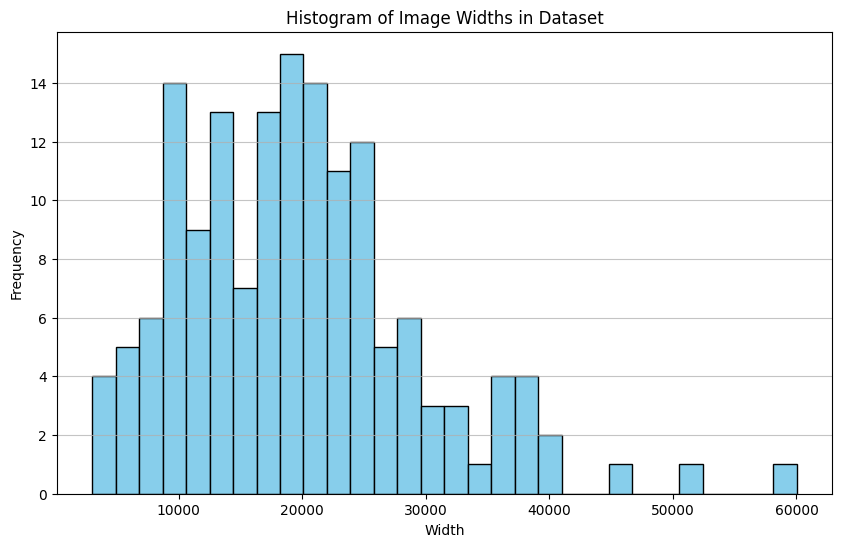

In [73]:
import matplotlib.pyplot as plt

widths = []

for sample in ds:
    img = np.array(sample['image'])
    widths.append(img.shape[1])  

widths = np.array(widths)

plt.figure(figsize=(10, 6))
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Image Widths in Dataset')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

> Видим, что длина очень разная и просто брать и превращать все спектограммы в квадрат - безумие.

In [74]:
subset[0]['text']

'soundtrack classical'

### Поэтому я превращу их в квадрат

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_transforms = transforms.Compose([
    transforms.Resize((128, 1028)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = models.resnet50(pretrained=True)
model = nn.Sequential(*(list(model.children())[:-1])) 
model.eval().to(device) 

def extract_image_features(image):
    image = image.convert("RGB")
    image_tensor = image_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image_tensor).cpu().numpy()
    return features.flatten()

/Users/akovel/anaconda3/envs/diploma/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akovel/anaconda3/envs/diploma/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Преобразуем изображения, для одинакового вида

In [91]:
X_images = np.array([extract_image_features(image) for image in ds['image']])

## Тренимся на изображениях. Смотрим в one hot encoding ЦЕЛИ жанров

In [92]:
X = X_images

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(ds['text'])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### В Pytorch 

In [94]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

## Baseline LogsisticRegressinModel

In [95]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, y.shape[1])

    def forward(self, x):
        return self.linear(x)

### Baseline CV Train

In [96]:
input_size = X.shape[1]
model = LogisticRegressionModel(input_size).to(device)

criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

print("Accuracy:", accuracy_score(y_test, predictions))

Epoch 0, Loss: 0.5242193937301636
Epoch 10, Loss: 0.3317989110946655
Epoch 20, Loss: 0.29196426272392273
Epoch 30, Loss: 0.2641342282295227
Epoch 40, Loss: 0.2588956952095032
Epoch 50, Loss: 0.20149607956409454
Epoch 60, Loss: 0.2096187025308609
Epoch 70, Loss: 0.19369053840637207
Epoch 80, Loss: 0.17578700184822083
Epoch 90, Loss: 0.15726634860038757
Accuracy: 0.03225806451612903


## Пока получили нулевую точность. Так, как вообще данных нет

## Напомню взял только 10 процентов

In [97]:
print(classification_report(y_test, predictions, target_names=mlb.classes_))

              precision    recall  f1-score   support

                   1.00      1.00      1.00        28
           0       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           a       0.83      0.96      0.89        25
           b       0.40      0.15      0.22        13
           c       0.85      0.88      0.86        25
           d       0.56      0.36      0.43        14
           e       0.79      0.96      0.87        24
           f       0.00      0.00      0.00         3
           g       0.50      0.17      0.25         6
           h       0.50      0.27      0.35        11
           i       0.83      1.00      0.91        25
           j       0.00      0.00      0.00         0
           k       0.67      0.27      0.38        15
           l       0.73      0.96      0.83        23
           m       0.43      0.27      0.33        11
           n       0.86      0.96      0.91        25
           o       0.93    

/Users/akovel/anaconda3/envs/diploma/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akovel/anaconda3/envs/diploma/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akovel/anaconda3/envs/diploma/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi